# Sentimental Analysis on US elections Tweets 
------------------

### Importing the Modules

In [352]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
#pip install plotly

sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loicb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\loicb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [353]:
import plotly.express as px

### Importing the Dataset

In [354]:
df = pd.read_excel  ('data/US2020.xlsx')
df.head()

Tweet Id                                               Text  \
0  1327225962661023755  RT @linfolibre : Puisque les trolls ne veulent...   
1  1327223379615772673  Joseph R. #Biden Jr. is the president-elect of...   
2  1327219804290347010  @TTuberville, who is about the be sworn in as ...   
3  1327211784101629952  Maptastic: How map makers will win the 2020 #U...   
4  1327209698655940608  #Biden cements victory by winning #Arizona, bu...   

                                            Name      Screen Name  \
0                                         Annick       Annickxena   
1                       Gender & Policy Insights  GenderPolicyIns   
2                                          Sarah     SarahMya2000   
3  Mike. Try out a bit of cognitive estrangement       RocketGoal   
4                           LBCI Lebanon News EN     LBCI_News_EN   

                        UTC                      Created At  Favorites  \
0  2020-11-13T12:25:02.000Z  Fri Nov 13 12:25:02 +0000 2020          0   
1  2020-11-13T12:14:46.000Z  Fri Nov 13 12:14:46 +0000 2020          0   
2  2020-11-13T12:00:34.000Z  Fri Nov 13 12:00:34 +0000 2020          0   
3  2020-11-13T11:28:42.000Z  Fri Nov 13 11:28:42 +0000 2020          0   
4  2020-11-13T11:20:25.000Z  Fri Nov 13 11:20:25 +0000 2020          6   

   Retweets Language                                             Client  \
0         0       fr  <a href="http://twitter.com/download/android" ...   
1         0       en  <a href="https://mobile.twitter.com" rel="nofo...   
2         0       en  <a href="http://twitter.com/download/iphone" r...   
3         0       en  <a href="https://mobile.twitter.com" rel="nofo...   
4         0       en  <a href="https://mobile.twitter.com" rel="nofo...   

  Tweet Type                                               URLs  Hashtags  \
0    Retweet  https://www.newsmax.com/newsmax-tv/trey-traino...         4   
1      Tweet                                                NaN         7   
2      Tweet  https://www.aldailynews.com/in-the-weeds-w-tom...        10   
3      Tweet                      https://youtu.be/Kb3YZs0F468          5   
4      Tweet  https://www.lbcgroup.tv/news/regional/559237/b...         5   

   Mentions Media Type                                       Media URLs  \
0         0        NaN                                              NaN   
1         0        NaN                                              NaN   
2         1      photo  https://pbs.twimg.com/media/Ems7YGOXIAcQ4UH.jpg   
3         1        NaN                                              NaN   
4         0        NaN                                              NaN   

  Unnamed: 16 Unnamed: 17 Unnamed: 18  
0         NaN         NaN         NaN  
1         NaN         NaN         NaN  
2         NaN         NaN         NaN  
3         NaN         NaN         NaN  
4         NaN         NaN         NaN

let's check the shape of the dataframe

In [355]:
df.shape

(2023, 19)

let's select the needed columns for our project

In [356]:
needed_columns = ['Name','Text','UTC']
df = df [needed_columns]
df.head()

Name  \
0                                         Annick   
1                       Gender & Policy Insights   
2                                          Sarah   
3  Mike. Try out a bit of cognitive estrangement   
4                           LBCI Lebanon News EN   

                                                Text                       UTC  
0  RT @linfolibre : Puisque les trolls ne veulent...  2020-11-13T12:25:02.000Z  
1  Joseph R. #Biden Jr. is the president-elect of...  2020-11-13T12:14:46.000Z  
2  @TTuberville, who is about the be sworn in as ...  2020-11-13T12:00:34.000Z  
3  Maptastic: How map makers will win the 2020 #U...  2020-11-13T11:28:42.000Z  
4  #Biden cements victory by winning #Arizona, bu...  2020-11-13T11:20:25.000Z

change the type of some columns

In [357]:
df.Name = df.Name.astype('category')
df.Name = df.Name.cat.codes

df.UTC = pd.to_datetime(df.UTC).dt.date
df.head()

Name                                               Text         UTC
0   111  RT @linfolibre : Puisque les trolls ne veulent...  2020-11-13
1   477  Joseph R. #Biden Jr. is the president-elect of...  2020-11-13
2  1129  @TTuberville, who is about the be sworn in as ...  2020-11-13
3   876  Maptastic: How map makers will win the 2020 #U...  2020-11-13
4   721  #Biden cements victory by winning #Arizona, bu...  2020-11-13

### Picking out the tweet texts

In [358]:
texts = df['Text']
texts

0       RT @linfolibre : Puisque les trolls ne veulent...
1       Joseph R. #Biden Jr. is the president-elect of...
2       @TTuberville, who is about the be sworn in as ...
3       Maptastic: How map makers will win the 2020 #U...
4       #Biden cements victory by winning #Arizona, bu...
                              ...                        
2018    CNA: ‘We're going to win this race': Biden pre...
2019    RT @AlArabiya_Eng : ICYMI: Two men armed with ...
2020    RT @SrezahJ : As an Iranian student, It's not ...
2021    RT @prclondon : Palestinian-American women Ras...
2022    Elections are heating up but Gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing URLs from tweets

In [359]:
remove_url = lambda x: re.sub(r'https\S+' , '', str(x))
texts_lr = texts.apply(remove_url)
texts_lr

0       RT @linfolibre : Puisque les trolls ne veulent...
1       Joseph R. #Biden Jr. is the president-elect of...
2       @TTuberville, who is about the be sworn in as ...
3       Maptastic: How map makers will win the 2020 #U...
4       #Biden cements victory by winning #Arizona, bu...
                              ...                        
2018    CNA: ‘We're going to win this race': Biden pre...
2019    RT @AlArabiya_Eng : ICYMI: Two men armed with ...
2020    RT @SrezahJ : As an Iranian student, It's not ...
2021    RT @prclondon : Palestinian-American women Ras...
2022    Elections are heating up but Gold got no chill...
Name: Text, Length: 2023, dtype: object

### Converting all tweets to lowercase

In [360]:
to_lower = lambda x : x.lower()
texts_lr_lc = texts_lr.apply(to_lower)
texts_lr_lc

0       rt @linfolibre : puisque les trolls ne veulent...
1       joseph r. #biden jr. is the president-elect of...
2       @ttuberville, who is about the be sworn in as ...
3       maptastic: how map makers will win the 2020 #u...
4       #biden cements victory by winning #arizona, bu...
                              ...                        
2018    cna: ‘we're going to win this race': biden pre...
2019    rt @alarabiya_eng : icymi: two men armed with ...
2020    rt @srezahj : as an iranian student, it's not ...
2021    rt @prclondon : palestinian-american women ras...
2022    elections are heating up but gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing punctuations

In [361]:
remove_puncs = lambda x : x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np

0       rt linfolibre  puisque les trolls ne veulent p...
1       joseph r biden jr is the presidentelect of the...
2       ttuberville who is about the be sworn in as a ...
3       maptastic how map makers will win the 2020 us ...
4       biden cements victory by winning arizona but t...
                              ...                        
2018    cna ‘were going to win this race biden predict...
2019    rt alarabiyaeng  icymi two men armed with hand...
2020    rt srezahj  as an iranian student its not impo...
2021    rt prclondon  palestinianamerican women rashid...
2022    elections are heating up but gold got no chill...
Name: Text, Length: 2023, dtype: object

### Removing stopwords

In [362]:
more_words = ['even','election2020','rt','elections','election', 'us', 'après', 'going','ccp','news','chinas']
stop_words = set(stopwords.words())
stop_words.update(more_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0       linfolibre puisque trolls veulent entendre par...
1       joseph r biden jr presidentelect united states...
2       ttuberville sworn senator thinks three branche...
3       maptastic map makers win 2020 help explain imp...
4       biden cements victory winning arizona trump st...
                              ...                        
2018    cna ‘were win race biden predicts victory lead...
2019    alarabiyaeng icymi two armed handguns arrested...
2020    srezahj iranian student important win election...
2021    prclondon palestinianamerican women rashida tl...
2022    heating gold got chill uselectionresults2020 c...
Name: Text, Length: 2023, dtype: object

### let's create a big list of words out of all the tweets 

In [363]:
words_list = [word for line in texts_lr_lc_np_ns for word in line.split()]

In [364]:
word_counts = Counter(words_list).most_common(30)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word','frq']
words_df.head()

word  frq
0      joebiden  656
1      ccpchina  366
2  gordongchang  364
3         trump  352
4  presidential  341

In [365]:
#conda install -c plotly plotly-orca

In [366]:
fig = px.bar(words_df, x='word',y='frq',title='Most common words', color='frq')
fig.write_image("img/Mostcommonwords.png", width=1960, height=1080)
fig.show()

In [367]:
#pip install wordcloud

In [368]:
all_words = ' ' .join([text for text in words_df['word']])

In [369]:
from wordcloud import WordCloud

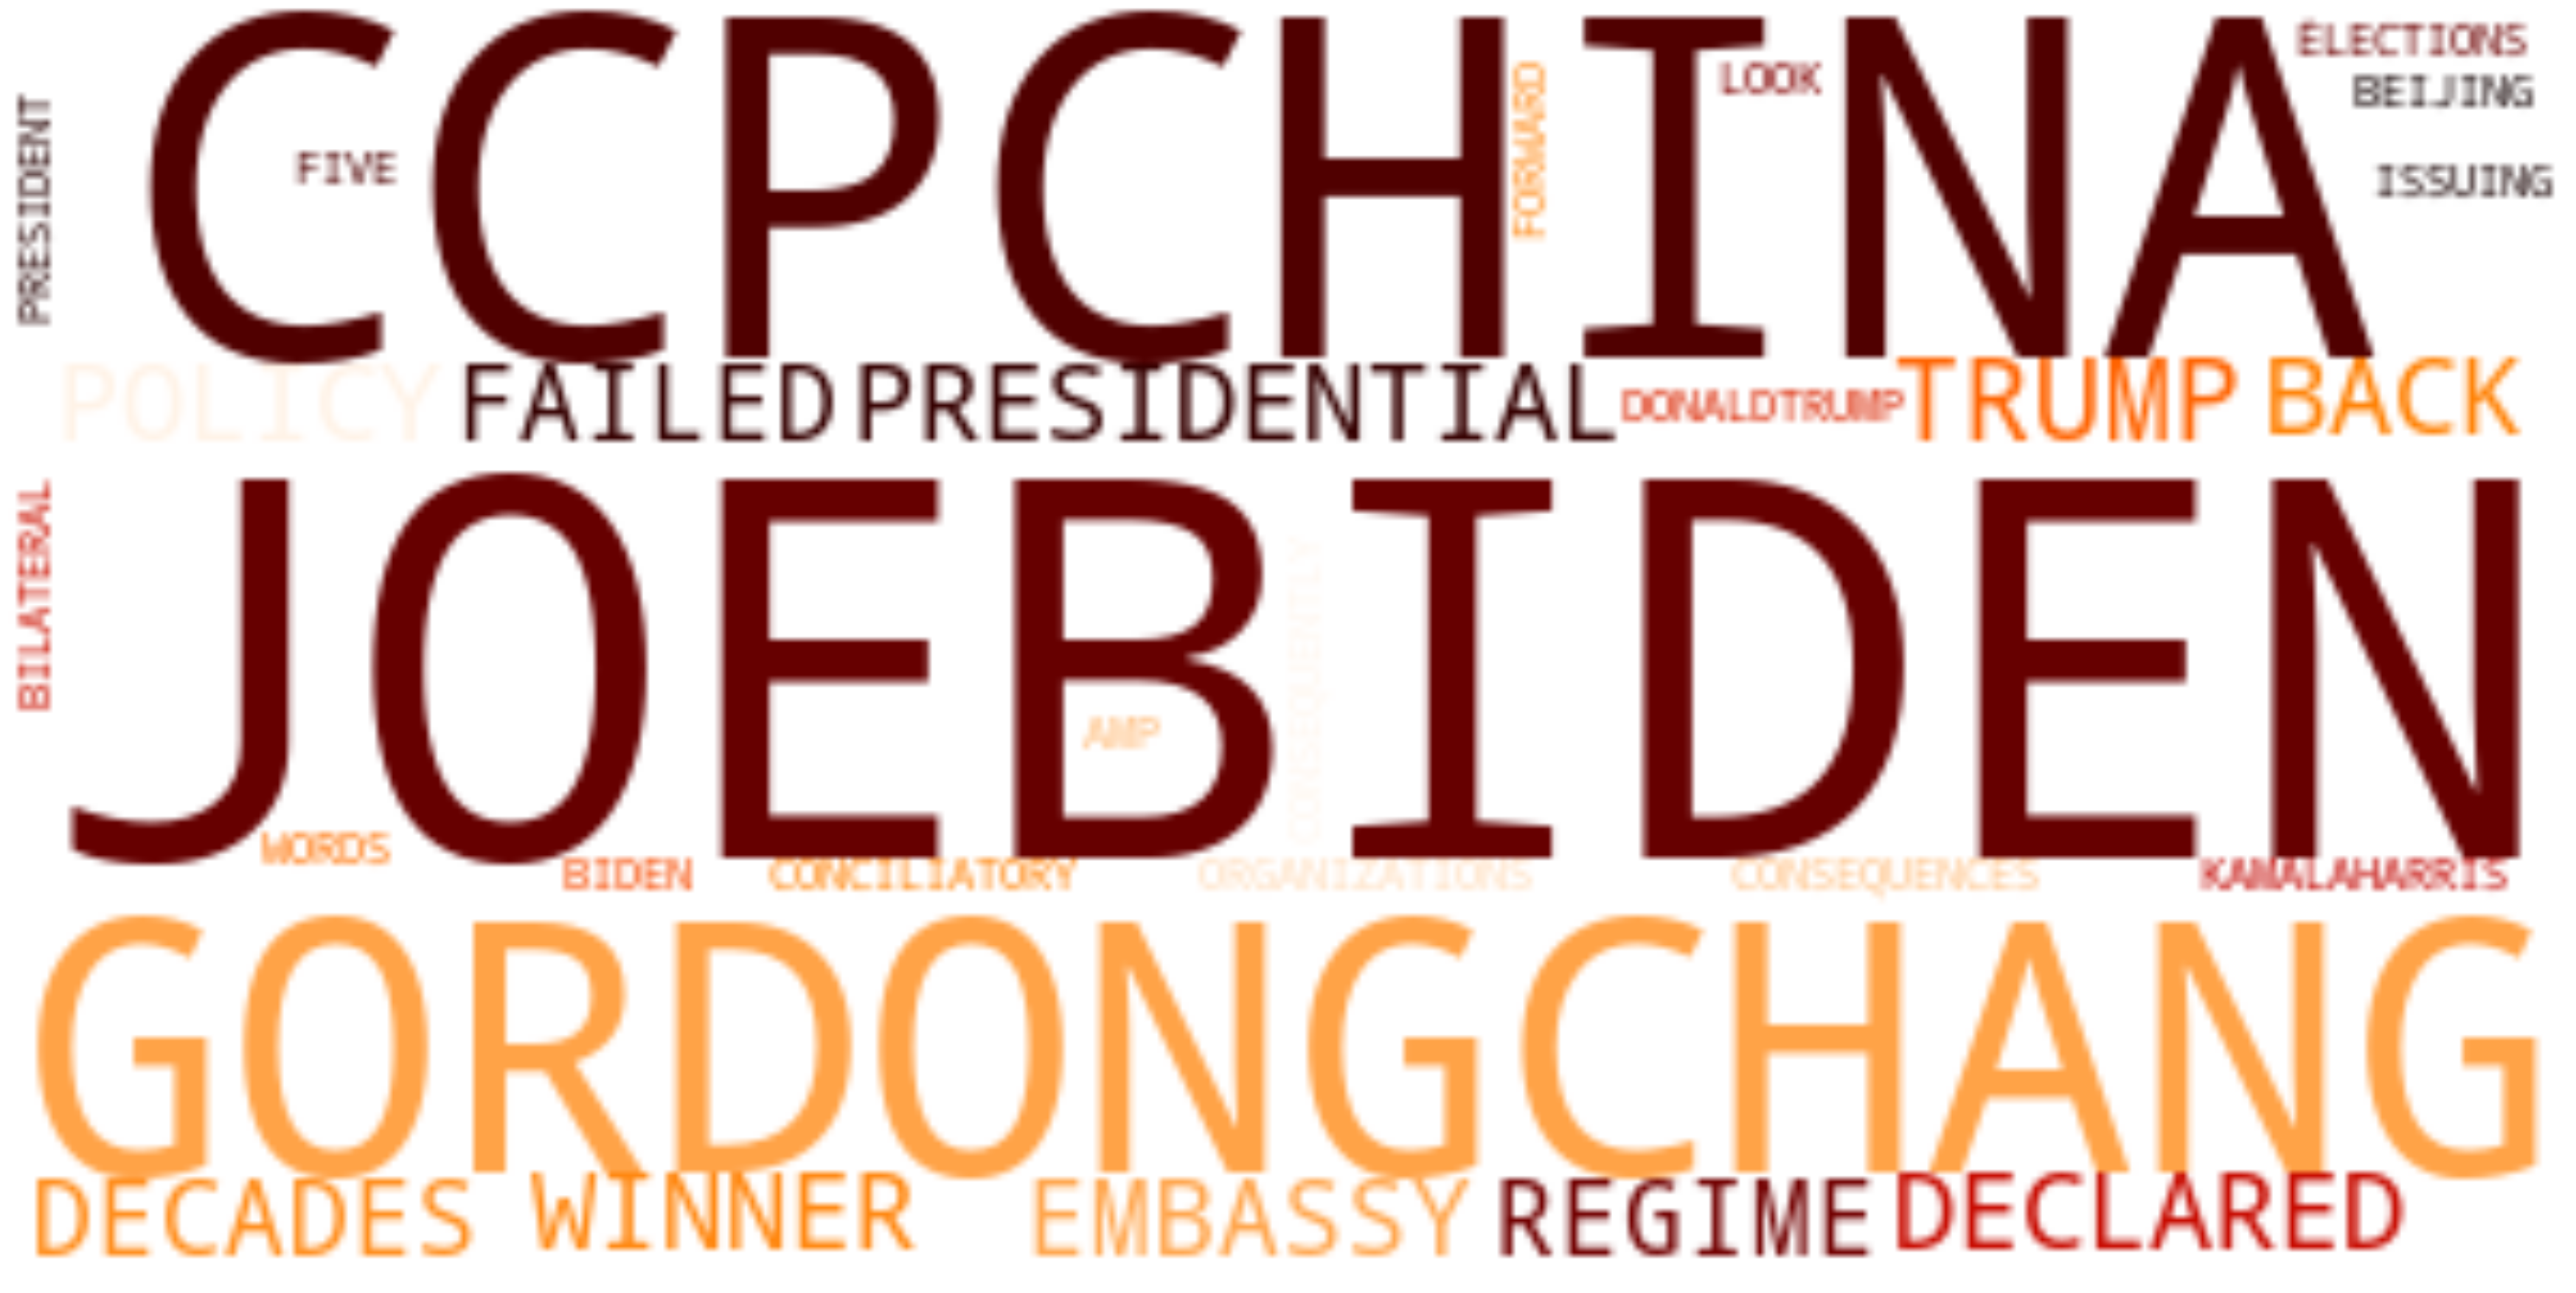

In [370]:
word_cloud = WordCloud(background_color='white', max_font_size=300,
                      max_words=50000, colormap='gist_heat')
word_cloud.generate(all_words.upper())
fig = plt.figure(figsize=[64, 32])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()
fig.savefig('img/wordcloud.png')

### put the Cleaned text in main dataframe

In [371]:
dftext = texts_lr_lc_np_ns
df.head()

Name                                               Text         UTC
0   111  RT @linfolibre : Puisque les trolls ne veulent...  2020-11-13
1   477  Joseph R. #Biden Jr. is the president-elect of...  2020-11-13
2  1129  @TTuberville, who is about the be sworn in as ...  2020-11-13
3   876  Maptastic: How map makers will win the 2020 #U...  2020-11-13
4   721  #Biden cements victory by winning #Arizona, bu...  2020-11-13

# Sentiment Analysis 

Getting the polarity scores for each tweet

In [372]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.Text.apply(ps)
sentiment_scores

0       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1       {'neg': 0.086, 'neu': 0.914, 'pos': 0.0, 'comp...
2       {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3       {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...
4       {'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...
                              ...                        
2018    {'neg': 0.117, 'neu': 0.834, 'pos': 0.049, 'co...
2019    {'neg': 0.1, 'neu': 0.9, 'pos': 0.0, 'compound...
2020    {'neg': 0.03, 'neu': 0.774, 'pos': 0.196, 'com...
2021    {'neg': 0.0, 'neu': 0.814, 'pos': 0.186, 'comp...
2022    {'neg': 0.113, 'neu': 0.887, 'pos': 0.0, 'comp...
Name: Text, Length: 2023, dtype: object

In [373]:
sentiment_df = pd.DataFrame (data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.000  1.000  0.000    0.0000
1  0.086  0.914  0.000   -0.4767
2  0.000  1.000  0.000    0.0000
3  0.000  0.727  0.273    0.8402
4  0.000  0.864  0.136    0.2960

### Labeling the scores based on the compound polarity value

In [374]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     label
0  0.000  1.000  0.000    0.0000   neutral
1  0.086  0.914  0.000   -0.4767  negative
2  0.000  1.000  0.000    0.0000   neutral
3  0.000  0.727  0.273    0.8402  positive
4  0.000  0.864  0.136    0.2960  positive

### let's join two dataframes

In [375]:
data = df.join (sentiment_df.label)
data.head()

Name                                               Text         UTC  \
0   111  RT @linfolibre : Puisque les trolls ne veulent...  2020-11-13   
1   477  Joseph R. #Biden Jr. is the president-elect of...  2020-11-13   
2  1129  @TTuberville, who is about the be sworn in as ...  2020-11-13   
3   876  Maptastic: How map makers will win the 2020 #U...  2020-11-13   
4   721  #Biden cements victory by winning #Arizona, bu...  2020-11-13   

      label  
0   neutral  
1  negative  
2   neutral  
3  positive  
4  positive

### Plotting the sentiment score counts

In [376]:
count_df = data.label.value_counts().reset_index()
count_df

index  label
0  positive   1076
1   neutral    643
2  negative    304

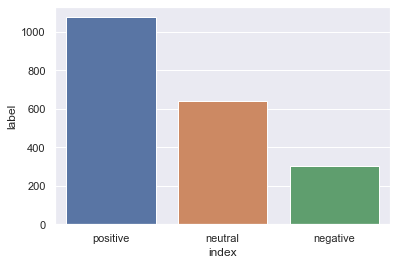

In [377]:
fig = sns.barplot(x='index', y='label', data= count_df)
# Saving the Seaborn Figure:
plt.savefig('img/count.png')

In [378]:
data.head()

Name                                               Text         UTC  \
0   111  RT @linfolibre : Puisque les trolls ne veulent...  2020-11-13   
1   477  Joseph R. #Biden Jr. is the president-elect of...  2020-11-13   
2  1129  @TTuberville, who is about the be sworn in as ...  2020-11-13   
3   876  Maptastic: How map makers will win the 2020 #U...  2020-11-13   
4   721  #Biden cements victory by winning #Arizona, bu...  2020-11-13   

      label  
0   neutral  
1  negative  
2   neutral  
3  positive  
4  positive

In [379]:
data_agg = data [['Name','UTC','label']].groupby (['UTC','label']).count().reset_index()
data_agg.columns = ['UTC','label','counts']
data_agg.head()

UTC     label  counts
0  2020-11-07  negative      63
1  2020-11-07   neutral     121
2  2020-11-07  positive     448
3  2020-11-08  negative      34
4  2020-11-08   neutral     235

In [380]:
fig = px.line(data_agg, x='UTC', y='counts', color='label', title = 'daily tweets sentimental analysis')
fig.write_image("img/daily tweets sentimental analysis.png",width=1000, height=500)
fig.show()

In [381]:
df = pd.read_excel  ('data/@JoeBiden_user_tweets.xlsx')
df.head()

Tweet Id                                               Text  \
0  1327649998092214273  To the millions of Hindus, Jains, Sikhs, and B...   
1  1327418361001676800  I am the president-elect, but will not be pres...   
2  1327418359848300545  I am alarmed by the surge in reported COVID-19...   
3  1327394562906542080  As the remnants of Tropical Storm Eta continue...   
4  1327356814552305664  Today marks five years since the horrific ISIS...   

        Name Screen Name                       UTC  \
0  Joe Biden    JoeBiden  2020-11-14T16:30:00.000Z   
1  Joe Biden    JoeBiden  2020-11-14T01:09:34.000Z   
2  Joe Biden    JoeBiden  2020-11-14T01:09:33.000Z   
3  Joe Biden    JoeBiden  2020-11-13T23:35:00.000Z   
4  Joe Biden    JoeBiden  2020-11-13T21:05:00.000Z   

                       Created At  Favorites  Retweets Language  \
0  Sat Nov 14 16:30:00 +0000 2020     130344     11647       en   
1  Sat Nov 14 01:09:34 +0000 2020     163077     14984       en   
2  Sat Nov 14 01:09:33 +0000 2020     338152     26718       en   
3  Fri Nov 13 23:35:00 +0000 2020     149088     10576       en   
4  Fri Nov 13 21:05:00 +0000 2020     201598     15188       en   

                                              Client Tweet Type URLs  \
0  <a href="https://about.twitter.com/products/tw...      Tweet  NaN   
1  <a href="https://mobile.twitter.com" rel="nofo...      Reply  NaN   
2  <a href="https://mobile.twitter.com" rel="nofo...      Tweet  NaN   
3  <a href="https://about.twitter.com/products/tw...      Tweet  NaN   
4  <a href="https://about.twitter.com/products/tw...      Tweet  NaN   

   Hashtags  Mentions Media Type Media URLs Unnamed: 16 Unnamed: 17  \
0         1         1        NaN        NaN         NaN         NaN   
1         0         0        NaN        NaN         NaN         NaN   
2         0         0        NaN        NaN         NaN         NaN   
3         0         0        NaN        NaN         NaN         NaN   
4         0         0        NaN        NaN         NaN         NaN   

  Unnamed: 18  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

let's check the shape of the dataframe

In [382]:
df.shape

(3200, 19)

let's select the needed columns for our project

In [383]:
needed_columns = ['Name','Text','UTC']
df = df [needed_columns]
df.head()

Name                                               Text  \
0  Joe Biden  To the millions of Hindus, Jains, Sikhs, and B...   
1  Joe Biden  I am the president-elect, but will not be pres...   
2  Joe Biden  I am alarmed by the surge in reported COVID-19...   
3  Joe Biden  As the remnants of Tropical Storm Eta continue...   
4  Joe Biden  Today marks five years since the horrific ISIS...   

                        UTC  
0  2020-11-14T16:30:00.000Z  
1  2020-11-14T01:09:34.000Z  
2  2020-11-14T01:09:33.000Z  
3  2020-11-13T23:35:00.000Z  
4  2020-11-13T21:05:00.000Z

change the type of some columns

In [384]:
df.Name = df.Name.astype('category')
df.Name = df.Name.cat.codes

df.UTC = pd.to_datetime(df.UTC).dt.date
df.head()

Name                                               Text         UTC
0     0  To the millions of Hindus, Jains, Sikhs, and B...  2020-11-14
1     0  I am the president-elect, but will not be pres...  2020-11-14
2     0  I am alarmed by the surge in reported COVID-19...  2020-11-14
3     0  As the remnants of Tropical Storm Eta continue...  2020-11-13
4     0  Today marks five years since the horrific ISIS...  2020-11-13

### Picking out the tweet texts

In [385]:
texts = df['Text']
texts

0       To the millions of Hindus, Jains, Sikhs, and B...
1       I am the president-elect, but will not be pres...
2       I am alarmed by the surge in reported COVID-19...
3       As the remnants of Tropical Storm Eta continue...
4       Today marks five years since the horrific ISIS...
                              ...                        
3195    My administration will not cut Social Security...
3196    Our students and educators deserve better than...
3197    Every morning I get up, I think to myself, "Is...
3198    We have to end Citizens United, but we can't s...
3199    I've been fighting to protect — and expand — S...
Name: Text, Length: 3200, dtype: object

### Removing URLs from tweets

In [386]:
remove_url = lambda x: re.sub(r'https\S+' , '', str(x))
texts_lr = texts.apply(remove_url)
texts_lr

0       To the millions of Hindus, Jains, Sikhs, and B...
1       I am the president-elect, but will not be pres...
2       I am alarmed by the surge in reported COVID-19...
3       As the remnants of Tropical Storm Eta continue...
4       Today marks five years since the horrific ISIS...
                              ...                        
3195    My administration will not cut Social Security...
3196    Our students and educators deserve better than...
3197    Every morning I get up, I think to myself, "Is...
3198    We have to end Citizens United, but we can't s...
3199    I've been fighting to protect — and expand — S...
Name: Text, Length: 3200, dtype: object

### Converting all tweets to lowercase

In [387]:
to_lower = lambda x : x.lower()
texts_lr_lc = texts_lr.apply(to_lower)
texts_lr_lc

0       to the millions of hindus, jains, sikhs, and b...
1       i am the president-elect, but will not be pres...
2       i am alarmed by the surge in reported covid-19...
3       as the remnants of tropical storm eta continue...
4       today marks five years since the horrific isis...
                              ...                        
3195    my administration will not cut social security...
3196    our students and educators deserve better than...
3197    every morning i get up, i think to myself, "is...
3198    we have to end citizens united, but we can't s...
3199    i've been fighting to protect — and expand — s...
Name: Text, Length: 3200, dtype: object

### Removing punctuations

In [388]:
remove_puncs = lambda x : x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np

0       to the millions of hindus jains sikhs and budd...
1       i am the presidentelect but will not be presid...
2       i am alarmed by the surge in reported covid19 ...
3       as the remnants of tropical storm eta continue...
4       today marks five years since the horrific isis...
                              ...                        
3195    my administration will not cut social security...
3196    our students and educators deserve better than...
3197    every morning i get up i think to myself is be...
3198    we have to end citizens united but we cant sto...
3199    ive been fighting to protect — and expand — so...
Name: Text, Length: 3200, dtype: object

### Removing stopwords

In [389]:
more_words = ['even','election2020','rt','elections','election', 'us', 'après', 'going','ccp','news','chinas']
stop_words = set(stopwords.words())
stop_words.update(more_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0       millions hindus jains sikhs buddhists celebrat...
1       presidentelect president next year covid19 res...
2       alarmed surge reported covid19 infections hosp...
3       remnants tropical storm eta continue impact ea...
4       today marks five years since horrific isis ter...
                              ...                        
3195    administration cut social security medicare be...
3196    students educators deserve better four years b...
3197    every morning get think beau proud he’s made p...
3198    citizens united cant stop time eliminate priva...
3199    ive fighting protect — expand — social securit...
Name: Text, Length: 3200, dtype: object

### let's create a big list of words out of all the tweets 

In [390]:
words_list = [word for line in texts_lr_lc_np_ns for word in line.split()]

In [391]:
word_counts = Counter(words_list).most_common(30)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word','frq']
words_df.head()

word   frq
0          —  1027
1  president   769
2      trump   752
3     donald   591
4       need   432

In [392]:
#conda install -c plotly plotly-orca

In [393]:
fig = px.bar(words_df, x='word',y='frq',title='Most common words', color='frq')
fig.write_image("img/JoeBidenMostcommonwords.png", width=1960, height=1080)
fig.show()

In [394]:
#pip install wordcloud

In [395]:
all_words = ' ' .join([text for text in words_df['word']])

In [396]:
from wordcloud import WordCloud

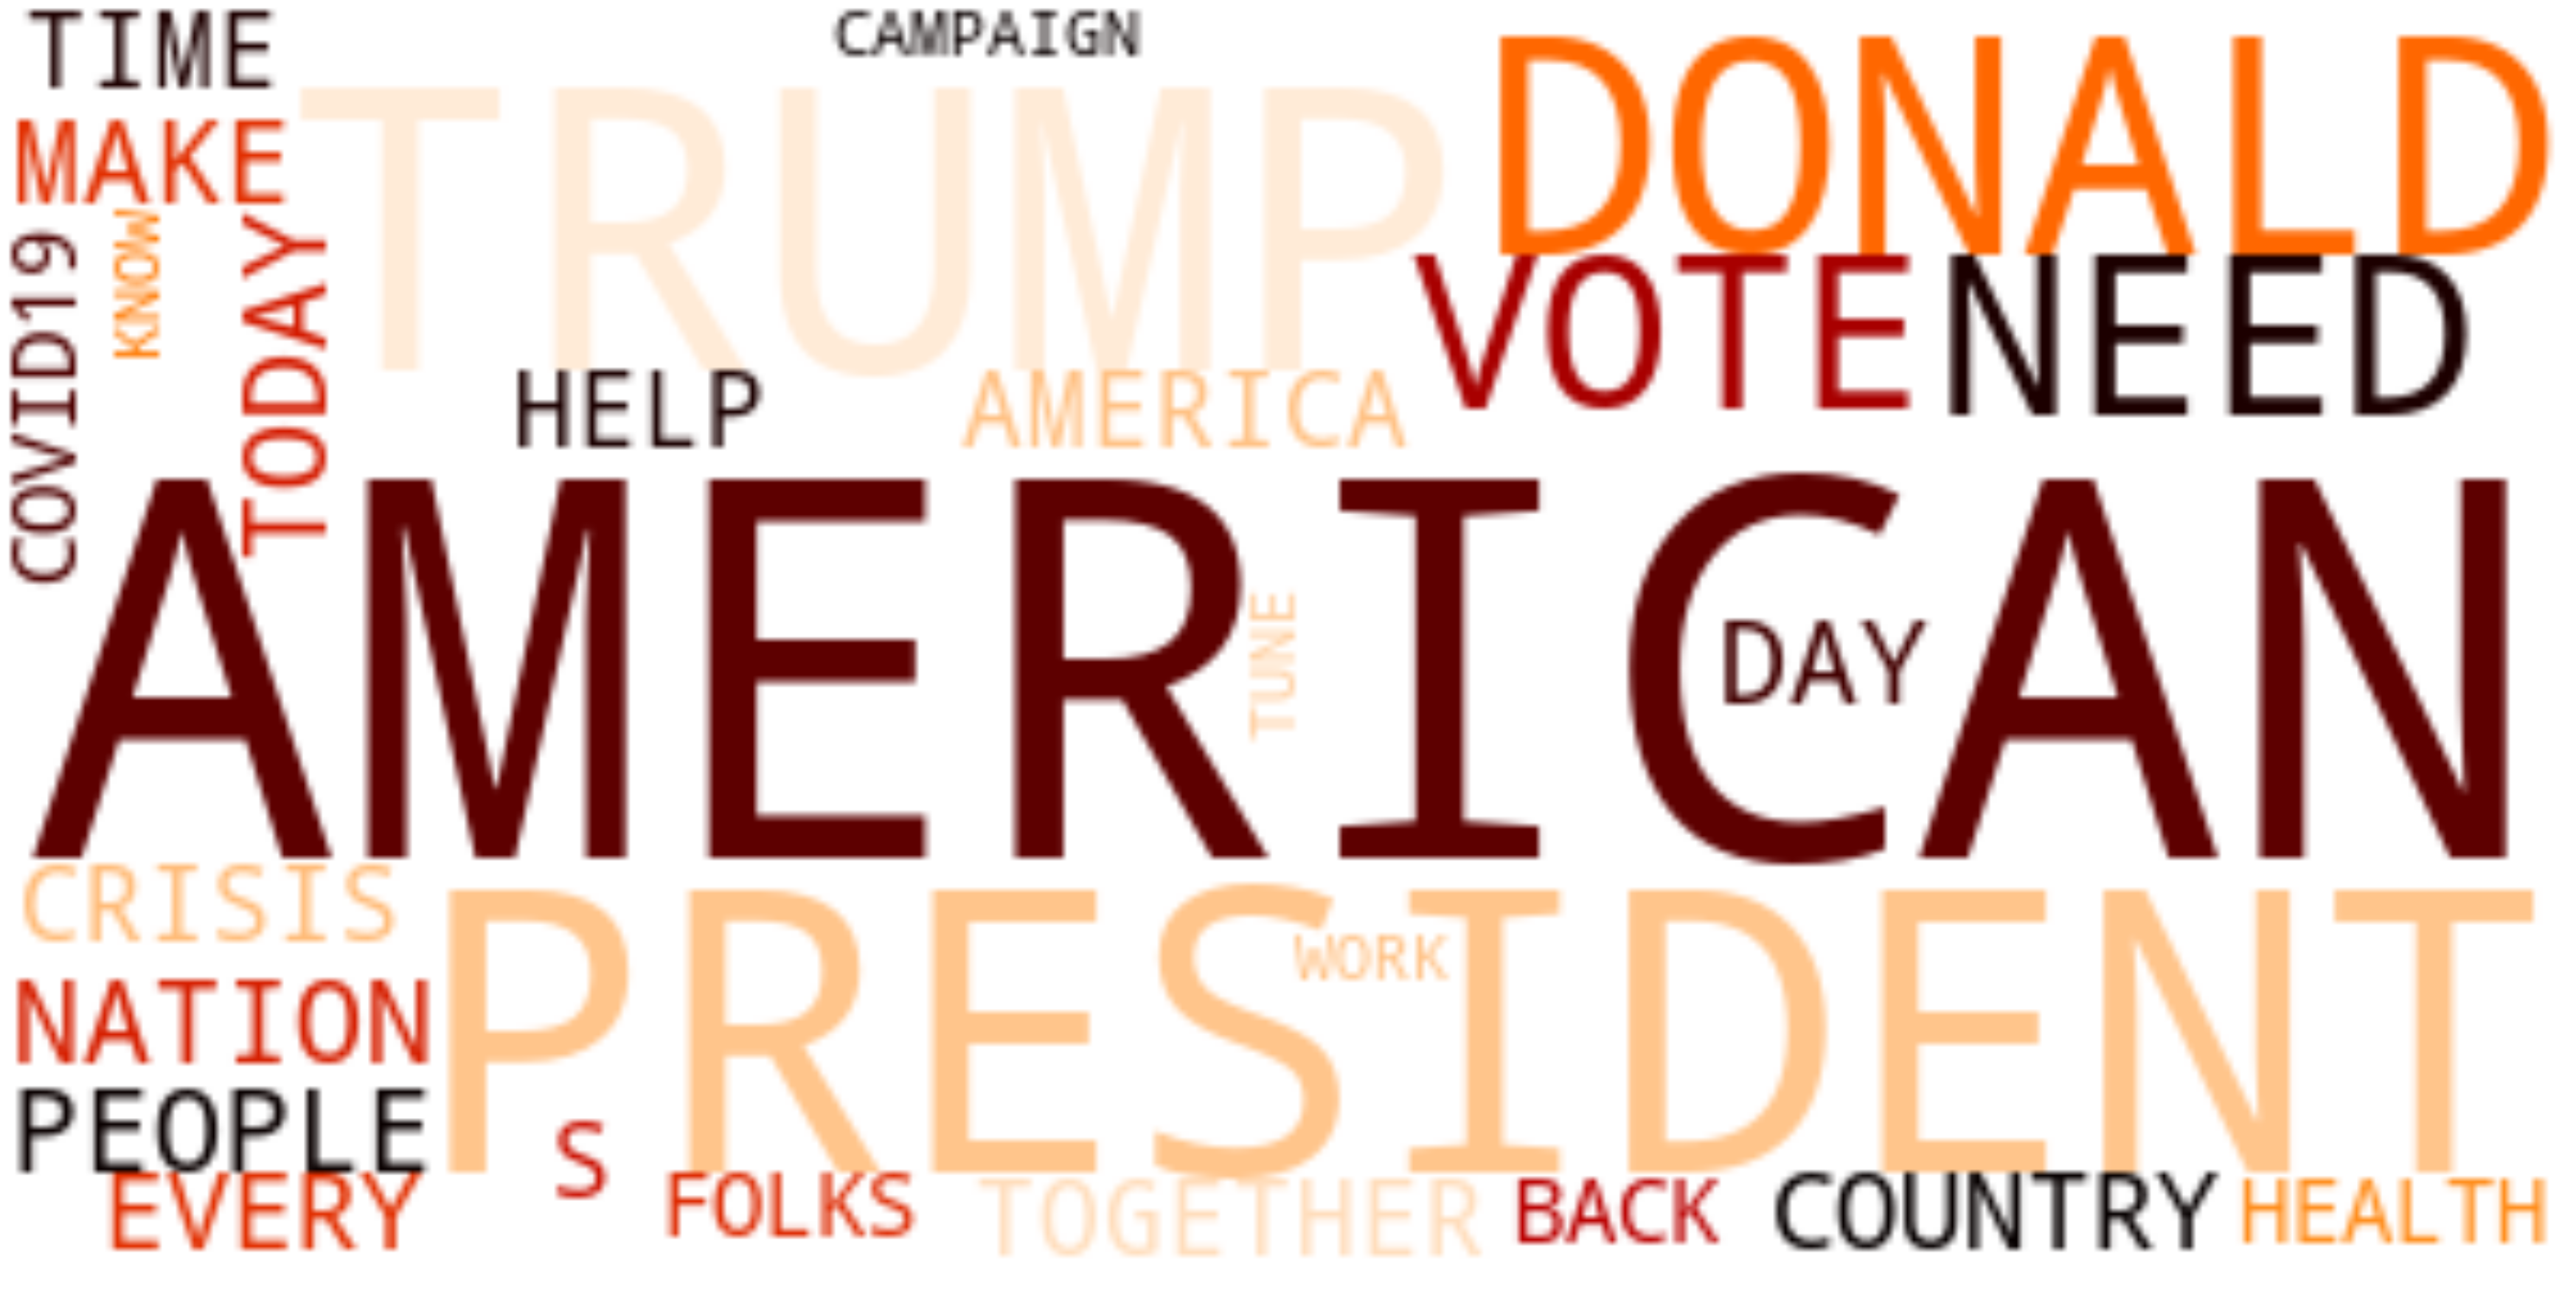

In [397]:
word_cloud = WordCloud(background_color='white', max_font_size=300,
                      max_words=50000, colormap='gist_heat')
word_cloud.generate(all_words.upper())
fig = plt.figure(figsize=[64, 32])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()
fig.savefig('img/JoeBidenwordcloud.png')

### put the Cleaned text in main dataframe

In [398]:
dftext = texts_lr_lc_np_ns
df.head()

Name                                               Text         UTC
0     0  To the millions of Hindus, Jains, Sikhs, and B...  2020-11-14
1     0  I am the president-elect, but will not be pres...  2020-11-14
2     0  I am alarmed by the surge in reported COVID-19...  2020-11-14
3     0  As the remnants of Tropical Storm Eta continue...  2020-11-13
4     0  Today marks five years since the horrific ISIS...  2020-11-13

# Sentiment Analysis 

Getting the polarity scores for each tweet

In [399]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.Text.apply(ps)
sentiment_scores

0       {'neg': 0.0, 'neu': 0.602, 'pos': 0.398, 'comp...
1       {'neg': 0.089, 'neu': 0.853, 'pos': 0.059, 'co...
2       {'neg': 0.369, 'neu': 0.563, 'pos': 0.068, 'co...
3       {'neg': 0.109, 'neu': 0.816, 'pos': 0.075, 'co...
4       {'neg': 0.352, 'neu': 0.593, 'pos': 0.055, 'co...
                              ...                        
3195    {'neg': 0.126, 'neu': 0.61, 'pos': 0.264, 'com...
3196    {'neg': 0.0, 'neu': 0.818, 'pos': 0.182, 'comp...
3197    {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...
3198    {'neg': 0.0, 'neu': 0.86, 'pos': 0.14, 'compou...
3199    {'neg': 0.194, 'neu': 0.554, 'pos': 0.253, 'co...
Name: Text, Length: 3200, dtype: object

In [400]:
sentiment_df = pd.DataFrame (data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.000  0.602  0.398    0.9595
1  0.089  0.853  0.059   -0.2803
2  0.369  0.563  0.068   -0.8934
3  0.109  0.816  0.075   -0.1280
4  0.352  0.593  0.055   -0.9615

### Labeling the scores based on the compound polarity value

In [401]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     label
0  0.000  0.602  0.398    0.9595  positive
1  0.089  0.853  0.059   -0.2803  negative
2  0.369  0.563  0.068   -0.8934  negative
3  0.109  0.816  0.075   -0.1280  negative
4  0.352  0.593  0.055   -0.9615  negative

### let's join two dataframes

In [402]:
data = df.join (sentiment_df.label)
data.head()

Name                                               Text         UTC  \
0     0  To the millions of Hindus, Jains, Sikhs, and B...  2020-11-14   
1     0  I am the president-elect, but will not be pres...  2020-11-14   
2     0  I am alarmed by the surge in reported COVID-19...  2020-11-14   
3     0  As the remnants of Tropical Storm Eta continue...  2020-11-13   
4     0  Today marks five years since the horrific ISIS...  2020-11-13   

      label  
0  positive  
1  negative  
2  negative  
3  negative  
4  negative

### Plotting the sentiment score counts

In [403]:
count_df = data.label.value_counts().reset_index()
count_df

index  label
0  positive   1754
1  negative    945
2   neutral    501

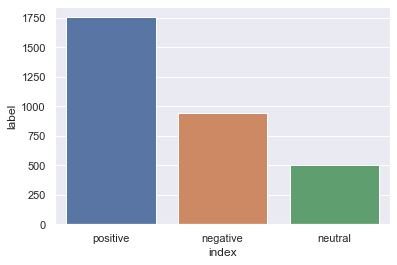

In [404]:
fig = sns.barplot(x='index', y='label', data= count_df)
# Saving the Seaborn Figure:
plt.savefig('img/JoeBidencount.png')

In [405]:
data.head()

Name                                               Text         UTC  \
0     0  To the millions of Hindus, Jains, Sikhs, and B...  2020-11-14   
1     0  I am the president-elect, but will not be pres...  2020-11-14   
2     0  I am alarmed by the surge in reported COVID-19...  2020-11-14   
3     0  As the remnants of Tropical Storm Eta continue...  2020-11-13   
4     0  Today marks five years since the horrific ISIS...  2020-11-13   

      label  
0  positive  
1  negative  
2  negative  
3  negative  
4  negative

In [406]:
data_agg = data [['Name','UTC','label']].groupby (['UTC','label']).count().reset_index()
data_agg.columns = ['UTC','label','counts']
data_agg.head()

UTC     label  counts
0  2020-01-22  negative       2
1  2020-01-22  positive       8
2  2020-01-23  negative       4
3  2020-01-23  positive       3
4  2020-01-24  negative       5

In [407]:
fig = px.line(data_agg, x='UTC', y='counts', color='label', title = 'daily tweets sentimental analysis')
fig.write_image("img/JoeBidendaily tweets sentimental analysis.png",width=1000, height=500)
fig.show()

In [408]:
df = pd.read_excel  ('data/@realDonaldTrump_user_tweets.xlsx')
df.head()

Tweet Id                                               Text  \
0  1327638503883235332  ....We cannot waste time and can only give to ...   
1  1327638502280925184  I LOVE NEW YORK! As everyone knows, the Trump ...   
2  1327633598686572544                            https://t.co/w9YruJ4AYc   
3  1327633164823617548  Congress must now do a Covid Relief Bill. Need...   
4  1327619654592892931  ....What are they trying to hide. They know, a...   

              Name      Screen Name                       UTC  \
0  Donald J. Trump  realDonaldTrump  2020-11-14T15:44:20.000Z   
1  Donald J. Trump  realDonaldTrump  2020-11-14T15:44:19.000Z   
2  Donald J. Trump  realDonaldTrump  2020-11-14T15:24:50.000Z   
3  Donald J. Trump  realDonaldTrump  2020-11-14T15:23:07.000Z   
4  Donald J. Trump  realDonaldTrump  2020-11-14T14:29:26.000Z   

                       Created At  Favorites  Retweets Language  \
0  Sat Nov 14 15:44:20 +0000 2020      67223     12708       en   
1  Sat Nov 14 15:44:19 +0000 2020     102837     21337       en   
2  Sat Nov 14 15:24:50 +0000 2020     117277     16986      und   
3  Sat Nov 14 15:23:07 +0000 2020     164125     26936       en   
4  Sat Nov 14 14:29:26 +0000 2020     133847     28209       en   

                                              Client Tweet Type URLs  \
0  <a href="http://twitter.com/download/iphone" r...      Reply  NaN   
1  <a href="http://twitter.com/download/iphone" r...      Tweet  NaN   
2  <a href="http://twitter.com/download/iphone" r...      Tweet  NaN   
3  <a href="http://twitter.com/download/iphone" r...      Tweet  NaN   
4  <a href="http://twitter.com/download/iphone" r...      Reply  NaN   

   Hashtags  Mentions Media Type  \
0         0         0        NaN   
1         0         1        NaN   
2         0         0      photo   
3         0         0        NaN   
4         0         0        NaN   

                                        Media URLs  
0                                              NaN  
1                                              NaN  
2  https://pbs.twimg.com/media/Emyzt5ZWMAoy5fh.jpg  
3                                              NaN  
4                                              NaN

let's check the shape of the dataframe

In [409]:
df.shape

(400, 16)

let's select the needed columns for our project

In [410]:
needed_columns = ['Name','Text','UTC']
df = df [needed_columns]
df.head()

Name                                               Text  \
0  Donald J. Trump  ....We cannot waste time and can only give to ...   
1  Donald J. Trump  I LOVE NEW YORK! As everyone knows, the Trump ...   
2  Donald J. Trump                            https://t.co/w9YruJ4AYc   
3  Donald J. Trump  Congress must now do a Covid Relief Bill. Need...   
4  Donald J. Trump  ....What are they trying to hide. They know, a...   

                        UTC  
0  2020-11-14T15:44:20.000Z  
1  2020-11-14T15:44:19.000Z  
2  2020-11-14T15:24:50.000Z  
3  2020-11-14T15:23:07.000Z  
4  2020-11-14T14:29:26.000Z

change the type of some columns

In [411]:
df.Name = df.Name.astype('category')
df.Name = df.Name.cat.codes

df.UTC = pd.to_datetime(df.UTC).dt.date
df.head()

Name                                               Text         UTC
0     0  ....We cannot waste time and can only give to ...  2020-11-14
1     0  I LOVE NEW YORK! As everyone knows, the Trump ...  2020-11-14
2     0                            https://t.co/w9YruJ4AYc  2020-11-14
3     0  Congress must now do a Covid Relief Bill. Need...  2020-11-14
4     0  ....What are they trying to hide. They know, a...  2020-11-14

### Picking out the tweet texts

In [412]:
texts = df['Text']
texts

0      ....We cannot waste time and can only give to ...
1      I LOVE NEW YORK! As everyone knows, the Trump ...
2                                https://t.co/w9YruJ4AYc
3      Congress must now do a Covid Relief Bill. Need...
4      ....What are they trying to hide. They know, a...
                             ...                        
395                              https://t.co/kKpYf6l0S1
396                              https://t.co/pHQwes68K3
397                              https://t.co/PRSxtZNspW
398                              https://t.co/aJCL8ocG8c
399    RT @TeamTrump : LIVE: Call to Prayer\n\nText V...
Name: Text, Length: 400, dtype: object

### Removing URLs from tweets

In [413]:
remove_url = lambda x: re.sub(r'https\S+' , '', str(x))
texts_lr = texts.apply(remove_url)
texts_lr

0      ....We cannot waste time and can only give to ...
1      I LOVE NEW YORK! As everyone knows, the Trump ...
2                                                       
3      Congress must now do a Covid Relief Bill. Need...
4      ....What are they trying to hide. They know, a...
                             ...                        
395                                                     
396                                                     
397                                                     
398                                                     
399    RT @TeamTrump : LIVE: Call to Prayer\n\nText V...
Name: Text, Length: 400, dtype: object

### Converting all tweets to lowercase

In [414]:
to_lower = lambda x : x.lower()
texts_lr_lc = texts_lr.apply(to_lower)
texts_lr_lc

0      ....we cannot waste time and can only give to ...
1      i love new york! as everyone knows, the trump ...
2                                                       
3      congress must now do a covid relief bill. need...
4      ....what are they trying to hide. they know, a...
                             ...                        
395                                                     
396                                                     
397                                                     
398                                                     
399    rt @teamtrump : live: call to prayer\n\ntext v...
Name: Text, Length: 400, dtype: object

### Removing punctuations

In [415]:
remove_puncs = lambda x : x.translate(str.maketrans('','',string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_puncs)
texts_lr_lc_np

0      we cannot waste time and can only give to thos...
1      i love new york as everyone knows the trump ad...
2                                                       
3      congress must now do a covid relief bill needs...
4      what are they trying to hide they know and so ...
                             ...                        
395                                                     
396                                                     
397                                                     
398                                                     
399    rt teamtrump  live call to prayer\n\ntext vote...
Name: Text, Length: 400, dtype: object

### Removing stopwords

In [416]:
more_words = ['even','election2020','rt','elections','election', 'us', 'après', 'going','ccp','news','chinas']
stop_words = set(stopwords.words())
stop_words.update(more_words)

remove_words = lambda x : ' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0      cannot waste time give states use vaccine imme...
1      love new york everyone knows trump administrat...
2                                                       
3      congress must covid relief bill needs democrat...
4            trying hide know everyone else expose crime
                             ...                        
395                                                     
396                                                     
397                                                     
398                                                     
399           teamtrump live call prayer text vote 88022
Name: Text, Length: 400, dtype: object

### let's create a big list of words out of all the tweets 

In [417]:
words_list = [word for line in texts_lr_lc_np_ns for word in line.split()]

In [418]:
word_counts = Counter(words_list).most_common(30)
words_df = pd.DataFrame(word_counts)
words_df.columns = ['word','frq']
words_df.head()

word  frq
0  biden   48
1   vote   43
2    win   34
3    amp   33
4  trump   31

In [419]:
#conda install -c plotly plotly-orca

In [420]:
fig = px.bar(words_df, x='word',y='frq',title='Most common words', color='frq')
fig.write_image("img/DonaldTrumpMostcommonwords.png", width=1960, height=1080)
fig.show()

In [421]:
#pip install wordcloud

In [422]:
all_words = ' ' .join([text for text in words_df['word']])

In [423]:
from wordcloud import WordCloud

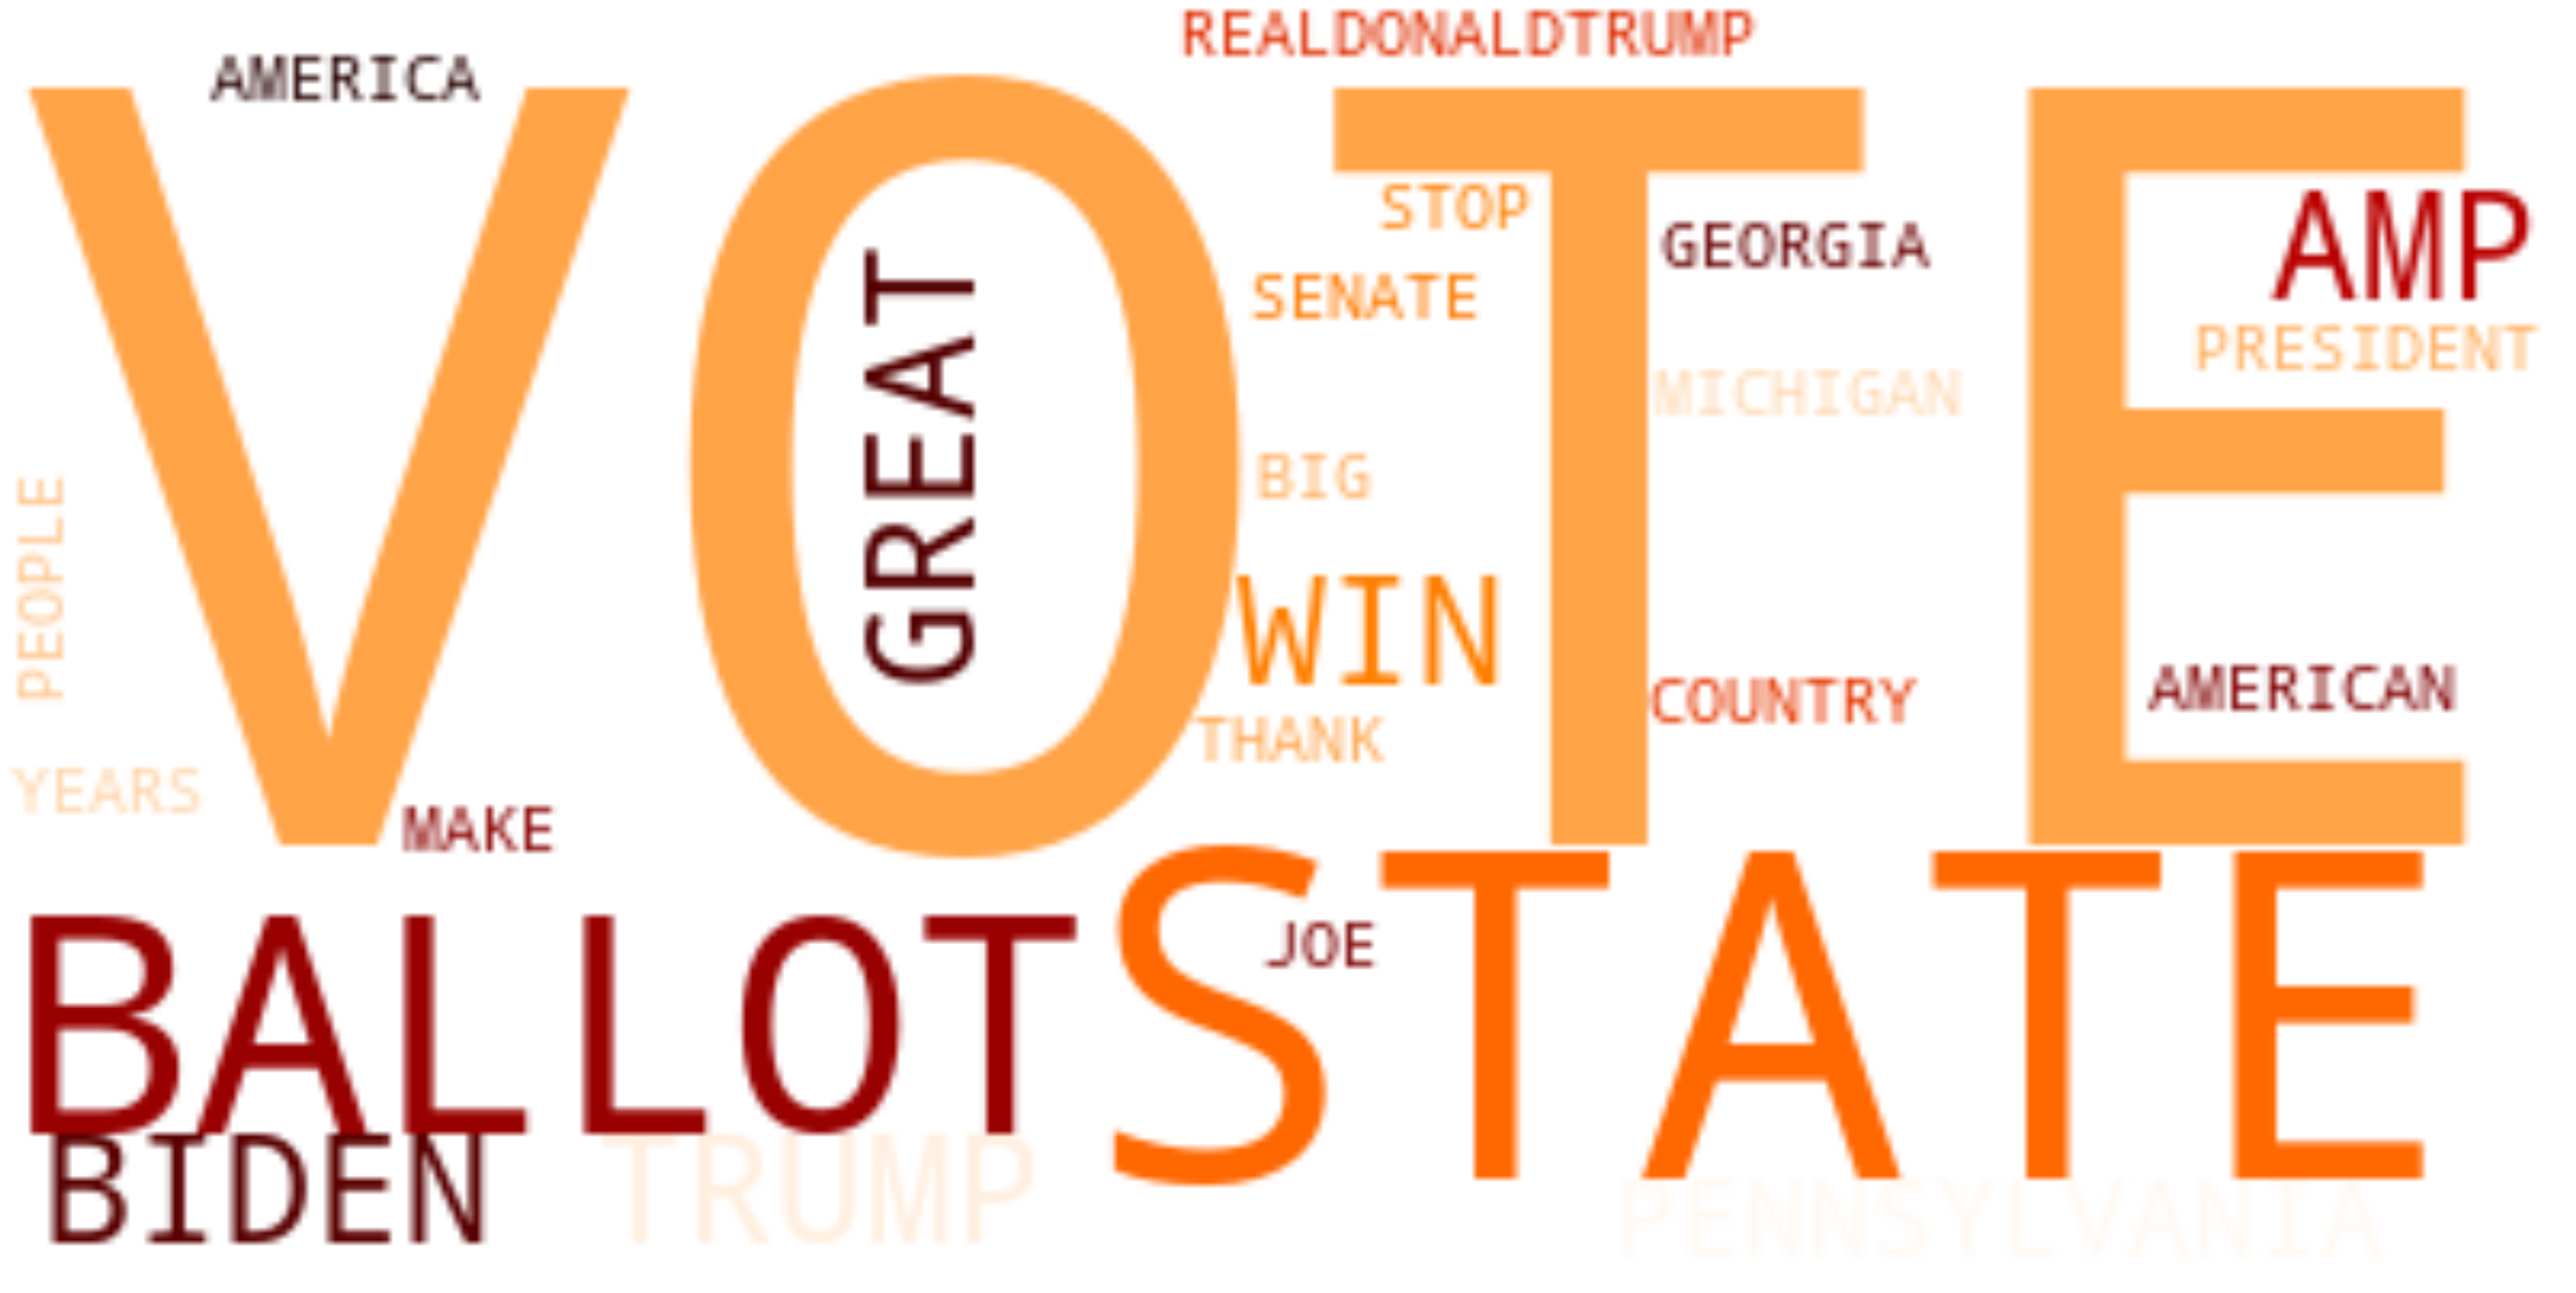

In [424]:
word_cloud = WordCloud(background_color='white', max_font_size=300,
                      max_words=50000, colormap='gist_heat')
word_cloud.generate(all_words.upper())
fig = plt.figure(figsize=[64, 32])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()
fig.savefig('img/DonaldTrumpwordcloud.png')

### put the Cleaned text in main dataframe

In [425]:
dftext = texts_lr_lc_np_ns
df.head()

Name                                               Text         UTC
0     0  ....We cannot waste time and can only give to ...  2020-11-14
1     0  I LOVE NEW YORK! As everyone knows, the Trump ...  2020-11-14
2     0                            https://t.co/w9YruJ4AYc  2020-11-14
3     0  Congress must now do a Covid Relief Bill. Need...  2020-11-14
4     0  ....What are they trying to hide. They know, a...  2020-11-14

# Sentiment Analysis 

Getting the polarity scores for each tweet

In [426]:
sid = SentimentIntensityAnalyzer()
ps = lambda x : sid.polarity_scores(x)
sentiment_scores = df.Text.apply(ps)
sentiment_scores

0      {'neg': 0.099, 'neu': 0.693, 'pos': 0.208, 'co...
1      {'neg': 0.089, 'neu': 0.658, 'pos': 0.253, 'co...
2      {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      {'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...
4      {'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'comp...
                             ...                        
395    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
396    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
397    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
398    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
399    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: Text, Length: 400, dtype: object

In [427]:
sentiment_df = pd.DataFrame (data = list(sentiment_scores))
sentiment_df.head()

neg    neu    pos  compound
0  0.099  0.693  0.208    0.5938
1  0.089  0.658  0.253    0.8822
2  0.000  1.000  0.000    0.0000
3  0.000  0.633  0.367    0.8268
4  0.397  0.603  0.000   -0.8205

### Labeling the scores based on the compound polarity value

In [428]:
labelize = lambda x : 'neutral' if x==0 else ('positive' if x>0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelize)
sentiment_df.head()

neg    neu    pos  compound     label
0  0.099  0.693  0.208    0.5938  positive
1  0.089  0.658  0.253    0.8822  positive
2  0.000  1.000  0.000    0.0000   neutral
3  0.000  0.633  0.367    0.8268  positive
4  0.397  0.603  0.000   -0.8205  negative

### let's join two dataframes

In [429]:
data = df.join (sentiment_df.label)
data.head()

Name                                               Text         UTC  \
0     0  ....We cannot waste time and can only give to ...  2020-11-14   
1     0  I LOVE NEW YORK! As everyone knows, the Trump ...  2020-11-14   
2     0                            https://t.co/w9YruJ4AYc  2020-11-14   
3     0  Congress must now do a Covid Relief Bill. Need...  2020-11-14   
4     0  ....What are they trying to hide. They know, a...  2020-11-14   

      label  
0  positive  
1  positive  
2   neutral  
3  positive  
4  negative

### Plotting the sentiment score counts

In [430]:
count_df = data.label.value_counts().reset_index()
count_df

index  label
0  positive    163
1   neutral    140
2  negative     97

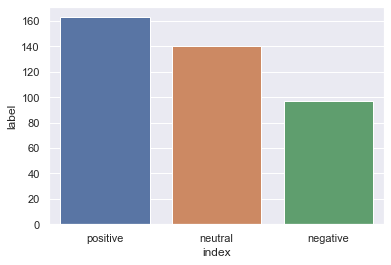

In [431]:
fig = sns.barplot(x='index', y='label', data= count_df)
# Saving the Seaborn Figure:
plt.savefig('img/DonaldTrumpcount.png')

In [432]:
data.head()

Name                                               Text         UTC  \
0     0  ....We cannot waste time and can only give to ...  2020-11-14   
1     0  I LOVE NEW YORK! As everyone knows, the Trump ...  2020-11-14   
2     0                            https://t.co/w9YruJ4AYc  2020-11-14   
3     0  Congress must now do a Covid Relief Bill. Need...  2020-11-14   
4     0  ....What are they trying to hide. They know, a...  2020-11-14   

      label  
0  positive  
1  positive  
2   neutral  
3  positive  
4  negative

In [433]:
data_agg = data [['Name','UTC','label']].groupby (['UTC','label']).count().reset_index()
data_agg.columns = ['UTC','label','counts']
data_agg.head()

UTC     label  counts
0  2020-11-01  negative       1
1  2020-11-01   neutral       5
2  2020-11-01  positive       3
3  2020-11-02  negative      14
4  2020-11-02   neutral      27

In [434]:
fig = px.line(data_agg, x='UTC', y='counts', color='label', title = 'daily tweets sentimental analysis')
fig.write_image("img/DonaldTrumpdaily tweets sentimental analysis.png",width=1000, height=500)
fig.show()